In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

In [2]:
class MultiHeadSelfAttention(layers.Layer):
    def __init__(self, embed_dim, num_heads=8):
        super(MultiHeadSelfAttention, self).__init__()
        self.embed_dim = embed_dim
        self.num_heads = num_heads
        if embed_dim % num_heads != 0:
            raise ValueError(
                f"embedding dimension = {embed_dim} should be divisible by number of heads = {num_heads}"
            )
        self.projection_dim = embed_dim // num_heads
        self.query_dense = layers.Dense(embed_dim)
        self.key_dense = layers.Dense(embed_dim)
        self.value_dense = layers.Dense(embed_dim)
        self.combine_heads = layers.Dense(embed_dim)

    def attention(self, query, key, value):
        score = tf.matmul(query, key, transpose_b=True)
        dim_key = tf.cast(tf.shape(key)[-1], tf.float32)
        scaled_score = score / tf.math.sqrt(dim_key)
        weights = tf.nn.softmax(scaled_score, axis=-1)
        output = tf.matmul(weights, value)
        return output, weights

    def separate_heads(self, x, batch_size):
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.projection_dim))
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs):
        # x.shape = [batch_size, seq_len, embedding_dim]
        batch_size = tf.shape(inputs)[0]
        query = self.query_dense(inputs)  # (batch_size, seq_len, embed_dim)
        key = self.key_dense(inputs)  # (batch_size, seq_len, embed_dim)
        value = self.value_dense(inputs)  # (batch_size, seq_len, embed_dim)
        query = self.separate_heads(
            query, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        key = self.separate_heads(
            key, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        value = self.separate_heads(
            value, batch_size
        )  # (batch_size, num_heads, seq_len, projection_dim)
        attention, weights = self.attention(query, key, value)
        attention = tf.transpose(
            attention, perm=[0, 2, 1, 3]
        )  # (batch_size, seq_len, num_heads, projection_dim)
        concat_attention = tf.reshape(
            attention, (batch_size, -1, self.embed_dim)
        )  # (batch_size, seq_len, embed_dim)
        output = self.combine_heads(
            concat_attention
        )  # (batch_size, seq_len, embed_dim)
        return output

In [3]:
class TransformerBlock(layers.Layer):
    def __init__(self, embed_dim, num_heads, ff_dim, rate=0.1):
        super(TransformerBlock, self).__init__()
        self.att = MultiHeadSelfAttention(embed_dim, num_heads)
        self.ffn = keras.Sequential(
            [layers.Dense(ff_dim, activation="relu"), layers.Dense(embed_dim),]
        )
        self.layernorm1 = layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = layers.LayerNormalization(epsilon=1e-6)
        self.dropout1 = layers.Dropout(rate)
        self.dropout2 = layers.Dropout(rate)

    def call(self, inputs, training):
        attn_output = self.att(inputs)
        attn_output = self.dropout1(attn_output, training=training)
        out1 = self.layernorm1(inputs + attn_output)
        ffn_output = self.ffn(out1)
        ffn_output = self.dropout2(ffn_output, training=training)
        return self.layernorm2(out1 + ffn_output)

In [4]:
class TokenAndPositionEmbedding(layers.Layer):
    def __init__(self, maxlen, vocab_size, emded_dim):
        super(TokenAndPositionEmbedding, self).__init__()
        self.token_emb = layers.Embedding(input_dim=vocab_size, output_dim=emded_dim)
        self.pos_emb = layers.Embedding(input_dim=maxlen, output_dim=emded_dim)

    def call(self, x):
        maxlen = tf.shape(x)[-1]
        positions = tf.range(start=0, limit=maxlen, delta=1)
        positions = self.pos_emb(positions)
        x = self.token_emb(x)
        return x + positions

# Prepare dataset

In [5]:
from konlpy.tag import Okt
okt = Okt()

_x = []
_y = []
stopwords = ['\n']
f = open("x_train.txt", 'r', encoding = 'UTF-8')
yf = open("y_train.txt", 'r', encoding = 'UTF-8')
while True :
    line = f.readline()
    if not line : break
    temp_X = []
    temp_X = okt.morphs(line) # 토큰화
    temp_X = [word for word in temp_X if not word in stopwords] # 불용어 제거
    _x.append(temp_X)
    temp_Y = yf.readline()[0]
    _y.append(int(temp_Y))
    
    
print(_x[:4])
print(_y[:4])

f.close()
yf.close()

[['20,000원', '을', '받으세요', '.'], ['20,000원', '받기', '완료', '!', '받은', '카카오', '페이', '머니는', '송금', '및', '온', '/', '오프라인', '결제', '는', '물론', ',', '투자', '도', '가능해요', '.'], ['이모티콘'], ['따룽행행']]
[0, 1, 1, 1]


In [6]:
from keras.preprocessing.text import Tokenizer
tokenizer = Tokenizer()
tokenizer.fit_on_texts(_x)

Using TensorFlow backend.


In [7]:
vocab_size = 6000  # Only consider the top 20k words
maxlen = 12  # Only consider the first 200 words of each movie review

import numpy as np
from sklearn.model_selection import train_test_split

x_train, x_val, y_train, y_val = train_test_split(_x, _y, test_size=0.2, random_state=321)

print(len(x_train), "Training sequences")
print(len(x_val), "Validation sequences")

x_train = tokenizer.texts_to_sequences(x_train)
x_val = tokenizer.texts_to_sequences(x_val)
y_train = np.array(y_train)
y_val = np.array(y_val)

4011 Training sequences
1003 Validation sequences


In [111]:
print(x_train[:3])

[[1614, 43, 4869, 23], [456, 15], [881, 882, 1279]]


In [8]:
from keras.preprocessing.sequence import pad_sequences
print('최대 길이 :',max(len(l) for l in x_train))
x_train = pad_sequences(x_train, maxlen = maxlen)
x_val = pad_sequences(x_val, maxlen = maxlen)

print(x_train[:3])

최대 길이 : 46
[[   0    0    0    0    0    0    0    0 1614   43 4869   23]
 [   0    0    0    0    0    0    0    0    0    0  456   15]
 [   0    0    0    0    0    0    0    0    0  881  882 1279]]


# Create classifier model using teansformer layer

In [9]:
embed_dim = 32  # Embedding size for each token
num_heads = 2  # Number of attention heads
ff_dim = 32  # Hidden layer size in feed forward network inside transformer
maxlen = 12 
vocab_size = 6000 

inputs = layers.Input(shape=(maxlen,))
embedding_layer = TokenAndPositionEmbedding(maxlen, vocab_size, embed_dim)
x = embedding_layer(inputs)
transformer_block = TransformerBlock(embed_dim, num_heads, ff_dim)
x = transformer_block(x)
x = layers.GlobalAveragePooling1D()(x)
x = layers.Dropout(0.1)(x)
x = layers.Dense(20, activation="relu")(x)
x = layers.Dropout(0.1)(x)
outputs = layers.Dense(2, activation="softmax")(x)

model = keras.Model(inputs=inputs, outputs=outputs)

In [10]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 12)]              0         
_________________________________________________________________
token_and_position_embedding (None, 12, 32)            192384    
_________________________________________________________________
transformer_block (Transform (None, 12, 32)            6464      
_________________________________________________________________
global_average_pooling1d (Gl (None, 32)                0         
_________________________________________________________________
dropout_2 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_6 (Dense)              (None, 20)                660       
_________________________________________________________________
dropout_3 (Dropout)          (None, 20)                0     

In [16]:
from tensorflow.keras.models import load_model
model.save('model')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
INFO:tensorflow:Assets written to: model\assets


In [7]:
import pydot, graphviz 
tf.keras.utils.plot_model(
    model, to_file='model.png', show_shapes=False, show_layer_names=True)

AttributeError: module 'os' has no attribute 'errno'

In [115]:
print(len(x_train))
print(len(y_train))
print(len(x_val))
print(len(y_val))

4011
4011
1003
1003


# Train and Evaluate

In [ ]:
model.compile("adam", "sparse_categorical_crossentropy", metrics=["accuracy"])
history = model.fit(
    x_train, y_train, batch_size=32, epochs=10000, validation_data=(x_val, y_val)
)

Epoch 1/10000
126/126 [==============================] - 1s 7ms/step - loss: 0.6775 - accuracy: 0.5734 - val_loss: 0.6484 - val_accuracy: 0.6271
Epoch 2/10000
126/126 [==============================] - 1s 5ms/step - loss: 0.5785 - accuracy: 0.6928 - val_loss: 0.6342 - val_accuracy: 0.6361
Epoch 3/10000
126/126 [==============================] - 0s 4ms/step - loss: 0.3954 - accuracy: 0.8330 - val_loss: 0.7248 - val_accuracy: 0.6461
Epoch 4/10000
126/126 [==============================] - 0s 4ms/step - loss: 0.2714 - accuracy: 0.8886 - val_loss: 0.8276 - val_accuracy: 0.6471
Epoch 5/10000
126/126 [==============================] - 0s 4ms/step - loss: 0.2216 - accuracy: 0.9080 - val_loss: 0.9822 - val_accuracy: 0.6381
Epoch 6/10000
126/126 [==============================] - 0s 4ms/step - loss: 0.1797 - accuracy: 0.9175 - val_loss: 1.1304 - val_accuracy: 0.6391
Epoch 7/10000
126/126 [==============================] - 0s 4ms/step - loss: 0.1622 - accuracy: 0.9225 - val_loss: 1.1394 - val_ac

In [121]:
print(model.evaluate(x_val, y_val))

32/32 [==============================] - 0s 1ms/step - loss: 2.3005 - accuracy: 0.6251
[2.300530195236206, 0.6251246333122253]


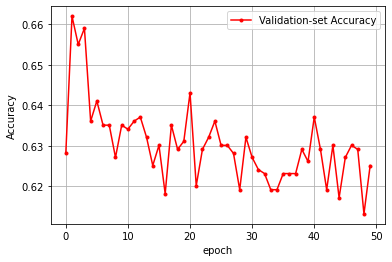

In [128]:
import matplotlib.pyplot as plt
y_vloss = history.history['val_accuracy']
y_loss = history.history['loss']
x_len = np.arange(len(y_loss))
plt.plot(x_len, y_vloss, marker='.', c='red', label="Validation-set Accuracy")
plt.legend(loc='upper right')
plt.grid()
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.show()